In [227]:
import mne
import numpy as np
import pandas as pd

In [228]:
# Load the raw bdf file
raw = mne.io.read_raw_bdf('/Users/tom/Desktop/psyco dat/test_arpan_2_20cm.bdf')

# drop all channels except A16, A13, A32, A31, A7, A24
raw.pick_channels(['A16', 'A13', 'A32', 'A31', 'A7', 'A24','Status','EXG7','EXG8'])

rename_map = {
    'A16': 'Oz',
    'A13': 'Pz',
    'A32': 'Cz',
    'A31': 'Fz',
    'A24': 'T8',
    'A7': 'T7'
}

# Rename channels
raw.rename_channels(rename_map)



Extracting EDF parameters from /Users/tom/Desktop/psyco dat/test_arpan_2_20cm.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | test_arpan_2_20cm.bdf, 9 x 2695168 (1316.0 s), ~14 KiB, data not loaded>

In [229]:
min_duration = (2) / raw.info['sfreq']
events = mne.find_events(raw, min_duration=min_duration)

# print unique event IDs
unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)

Trigger channel Status has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
4454 events found on stim channel Status
Event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65383]
Unique event IDs: [65281 65282 65283 65284 65285 65286 65287 65288 65289 65290 65291 65292
 65293 65294 65295 65296 65297 65298 65299 65381 65383]


In [230]:
logical_triggers = [x & 0xFF for x in events[:, 2]]
logical_triggers = pd.Series(logical_triggers, name='Logical Triggers')
print(logical_triggers.value_counts())

Logical Triggers
9      427
7      423
2      420
6      417
4      411
1      407
5      397
3      387
8      382
103    262
101    259
19      34
18      30
16      30
14      28
10      27
17      26
13      26
12      24
15      20
11      17
Name: count, dtype: int64


In [231]:
# re reference the data to average of T7 and T8
raw.load_data()  # Load the data into memory
raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'], projection=False)
# decimate the data to 256Hz
#raw.resample(256, npad='auto')
# filter above 30Hz lowpass
#raw.filter(None, 30, fir_design='firwin', skip_by_annotation='edge')
# Save the modified raw data to a new file
raw.save('/Users/tom/Desktop/psyco dat/test_2-raw.fif', overwrite=True)

Reading 0 ... 2695167  =      0.000 ...  1316.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Overwriting existing file.
Writing /Users/tom/Desktop/psyco dat/test_2-raw.fif
Closing /Users/tom/Desktop/psyco dat/test_2-raw.fif
[done]


[PosixPath('/Users/tom/Desktop/psyco dat/test_2-raw.fif')]

Number of events with logical event ID 19: 64
Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 2971 original time points ...
0 bad epochs dropped


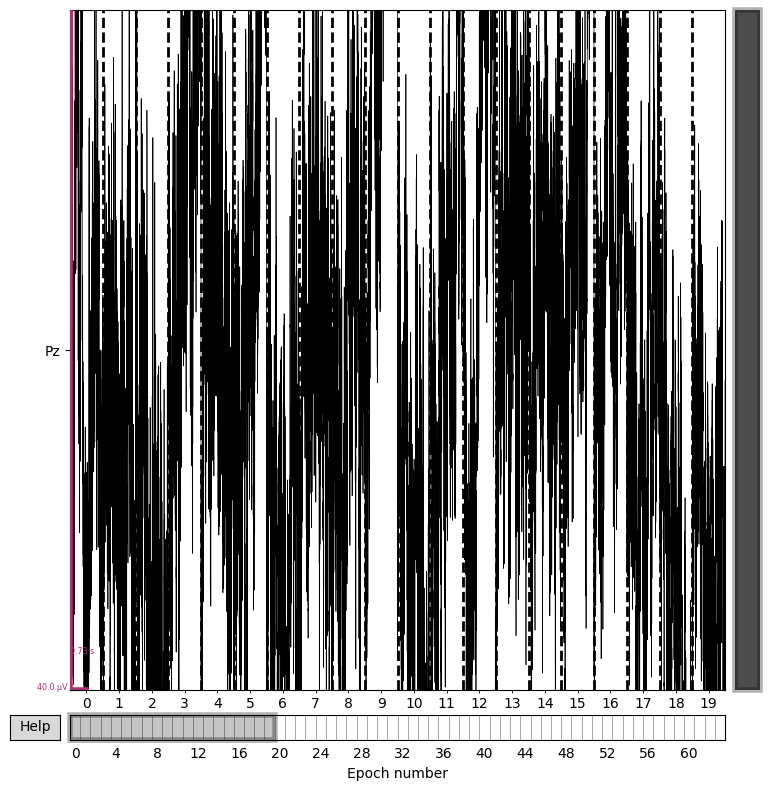

Need more than one channel to make topography for eeg. Disabling interactivity.


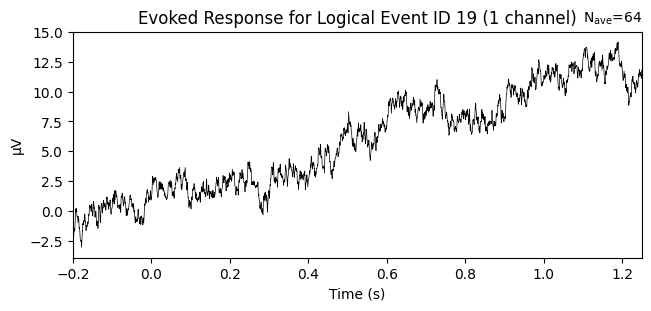

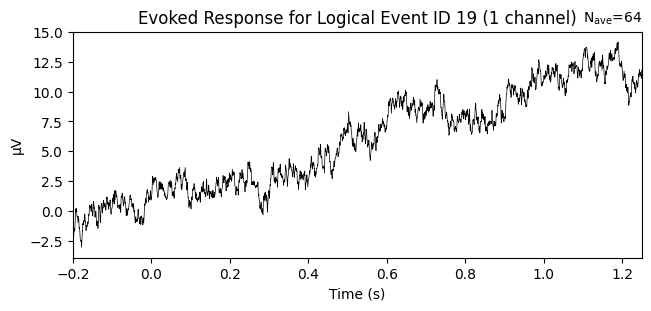

In [234]:
# Find indices of events with logical event ID 19
#mask = [(x & 0xFF) > 9 and (x & 0xFF) < 100 for x in events[:, 2]]
mask = (events[:, 2] & 0xFF) == 101
events_19 = events[mask]
# only take first 32 events
events_19 = events_19[:64]

reject = dict(eeg=1000e-6)  # Reject epochs with peak-to-peak amplitude > 100 µV

print(f"Number of events with logical event ID 19: {len(events_19)}")

# Define epoch parameters
tmin = -0.2  # start 200ms before the trigger
tmax = 1.25  
epochs = mne.Epochs(raw, events_19, tmin=tmin, tmax=tmax, baseline=(-0.2, 0),reject=None, detrend=None, preload=True)


epochs.plot(picks=['Pz'])

# Get evoked response for Pz
evoked = epochs.average().pick('Pz')


# Plot the evoked response
evoked.plot(titles='Evoked Response for Logical Event ID 19')